In [1]:
import os
import sys
import gdal
import json
sys.path.insert(0, os.path.abspath('..'))

from unittest.mock import MagicMock
from unittest.mock import Mock

import pandas as pd

from autocnet.fileio import io_gdal
from autocnet.cg import cg
from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.graph import edge
from autocnet.graph import node
from scipy.spatial import ConvexHull
from autocnet.matcher import suppression_funcs as spf

from osgeo import ogr

from IPython.display import display

%pylab inline
%matplotlib inline
fig=plt.figure(figsize=(25, 25), dpi= 30)

Populating the interactive namespace from numpy and matplotlib


In [2]:
adjacency = get_path('suppression_adjacency.json')
basepath = get_path('Apollo15')
cang1 = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cang1.extract_features(method='sift')

#Match
cang1.match_features(k=2)

#Apply outlier detection
cang1.symmetry_checks()
cang1.ratio_checks(clean_keys = ['symmetry'], single=True)

destination_df = pd.DataFrame(cang1.edge[0][1].destination._keypoints)
source_df = pd.DataFrame(cang1.edge[0][1].source._keypoints)

cang1.apply_func_to_edges("compute_fundamental_matrix", clean_keys=['ratio', 'symmetry'])

#print("Length of the error array: " + len(cang1.edge[0][1].fundamental_matrix.error).__str__())

cang1.suppress(suppression_func = spf.error, clean_keys = ['ratio', 'symmetry'], k = 15)

matches_df = cang1.edge[0][1].matches
matches_df['destination x'] = destination_df['x']
matches_df['destination y'] = destination_df['y']
matches_df['source x'] = source_df['x']
matches_df['source y'] = source_df['y']
matches_df['symmetry'] = cang1.edge[0][1].masks['symmetry']
matches_df['ratio'] = cang1.edge[0][1].masks['ratio']

/scratch/anaconda3/envs/autocnet/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)
/home/acpaquette/autocnet/autocnet/transformation/transformations.py:312: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  x = self.x1[self.mask]
/home/acpaquette/autocnet/autocnet/transformation/transformations.py:313: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  x1 = self.x2[self.mask]
/home/acpaquette/autocnet/autocnet/matcher/outlier_detector.py:262: UserWarning: Unable to optimally solve.  Returning with 17 points
  warnings.warn('Unable to optimally solve.  Returning with {} points'.format(len(result)))


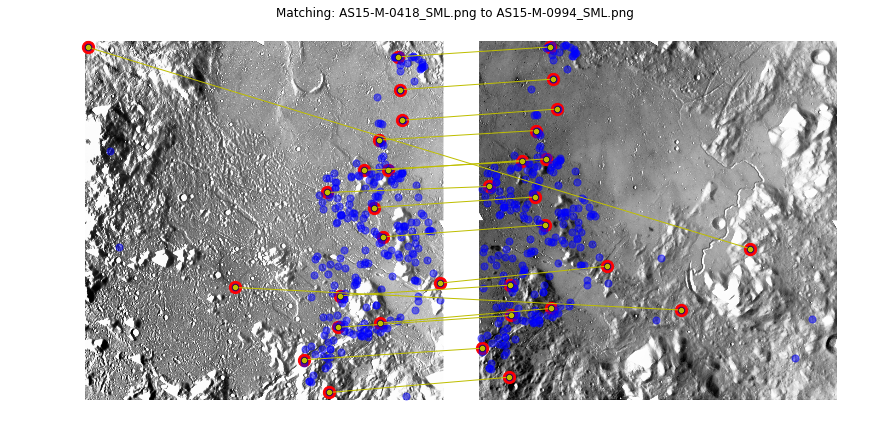

In [3]:
fig=plt.figure(figsize=(15, 15), dpi= 30)
cang1.edge[0][1].plot(clean_keys = ['suppression'], scatter_kwargs = {'color':'r', 's':150},
                      line_kwargs = {'marker':'o'})
cang1.edge[0][1].plot(clean_keys = ['fundamental'], scatter_kwargs = {'color':'b', 's':50, 'alpha':0.5}, 
                      line_kwargs = {'linewidth':0})

In [4]:
cang1.edge[0][1].fundamental_matrix.mask.sum()

252